In [191]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import ArtistAnimation

import nengo

import pandas as pd

In [192]:
def csv_to_event_array(
    csv_filename: str, start_frame: int, end_frame: int
) -> np.ndarray:
    # ======= DVS camera - Physics dept ===========
    df = pd.read_csv(csv_filename, names=["x", "y", "p", "t"])

    # set initial time to 0 for Nengo simulator to run data right away
    sub_df = df[(start_frame <= df["t"]) & (df["t"] <= end_frame)]

    sub_df["t"] = sub_df["t"] - sub_df["t"].iloc[0]

    events_list = [(y, x, p, t) for x, y, p, t in sub_df.values]
    events_array = np.array(
        events_list, dtype=[("y", "i4"), ("x", "i4"), ("p", "i4"), ("t", "i4")]
    )

    return events_array


# the csv file we will convert and the time range of our events

# ======== Prophesee camera - ECE dept ========
csv_filename = "newledpath.csv"
start_time = 0.95e6
end_time = 1.1e6
# =============================================

# Our events array we will feed in through a Nengo node
events = csv_to_event_array(csv_filename, start_time, end_time)
print("Successfully read %r" % csv_filename)
print(events)

C:\Users\C27Grant.Stec\AppData\Local\Temp\ipykernel_17524\2587564457.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["t"] = sub_df["t"] - sub_df["t"].iloc[0]


Successfully read 'newledpath.csv'
[(172, 837, 0,      0) (464, 615, 1,      3) (142, 711, 1,      4) ...
 ( 29, 740, 1, 149998) (369, 570, 1, 149998) (382, 749, 0, 149998)]


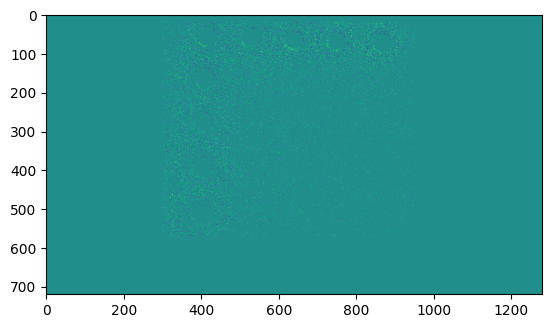

In [193]:
# ======== Prophesee camera - ECE dept ========
img_height = 720
img_width = 1280
t_length_us = end_time - start_time  # value is in microseconds
t_length_s = t_length_us * 1e-6  # convert prior value to seconds
dt_frame_us = (10 * 1e-3) * 1e6  # this value is also in microseconds
t_frames = dt_frame_us * np.arange(
    int(round(t_length_us / dt_frame_us))
)  # number of frames in video

fig = plt.figure()
imgs = []
for t_frame in t_frames:
    t0_us = t_frame
    t1_us = t0_us + dt_frame_us
    t = events[:]["t"]
    m = (t >= t0_us) & (t < t1_us)
    events_m = events[m]

    # Empty frame
    frame_img = np.zeros((img_height, img_width))

    for sub_event in events_m:
        # show "off" (0) events as -1 and "on" (1) events as +1
        event_sign = 2.0 * sub_event["p"] - 1
        frame_img[sub_event["y"], sub_event["x"]] = (
            frame_img[sub_event["y"], sub_event["x"]] + event_sign
        )

    img = plt.imshow(frame_img[:, ::1], vmin=-1, vmax=1, animated=True)
    imgs.append([img])

ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_jshtml())

In [194]:
# We'll make a simple object to implement the delayed connection
class readSpikeData:
    def __init__(self, event_data, img_height, img_width):
        self.xvals = event_data[:]["x"]
        self.yvals = event_data[:]["y"]
        self.time = event_data[:]["t"]
        self.pol = event_data[:]["p"]
        self.img_ht = img_height
        self.img_wt = img_width

    def step(self, t):

        dt = 0.001
        t_lower = (t - dt) * 1e6
        t_upper = t * 1e6
        x = 0

        times = self.time
        indices = np.nonzero((times >= t_lower) & (times < t_upper))[0]

        data = np.zeros((self.img_ht * self.img_wt * 2,), dtype=int)
        for index in indices:
            if self.pol[index] == 1:
                x += 1
                # Manually flatten data using (i*y_len)+j **note x,y vals swapped
                data[self.yvals[index] * self.img_wt + self.xvals[index]] = 1 / dt
            else:
                data[
                    self.img_ht * self.img_wt
                    + self.yvals[index] * self.img_wt
                    + self.xvals[index]
                ] = (1 / dt)
        return data


inp = readSpikeData(events, img_height, img_width)


In [195]:

model = nengo.Network(label="Spiking Data")
with model:
    input_node = nengo.Node(inp.step)

    input_neurons = nengo.Ensemble(img_height * img_width * 2, 1)

    nengo.Connection(input_node, input_neurons.neurons, transform=1)


    probes_nodes = nengo.Probe(input_node)
    probes = nengo.Probe(input_neurons.neurons)

    # My work

    pixel_range = 10  # the range of pixels from left to right and top to bottom so 10 creates a 10x10 square centered at the declared center
    probestart = []  # list of probes for the neurons activated around the first LED
    center_x = 400  # visually esatimated center of the first LED x
    center_y = 515  # visually estimated center of the first LED y
    pixel_coordinates = (
        []
    )  # list of the pixel coordinates that are being probed for first LED
    probeend = []  # list of probes for the neurons activated around the last LED
    centerend_x = 860  # visually estimated center of the last LED x
    centerend_y = 60  # visually estimated center of the last LED y
    pixelend_coordinates = (
        []
    )  # list of the pixel coordinates that are being probed for last LED

    # loop to get the neurons cordinated around the center
    for i in range(-pixel_range // 2, pixel_range // 2 + 1):
        for j in range(-pixel_range // 2, pixel_range // 2 + 1):
            # for start
            x = center_x + i
            y = center_y + j
            index = (
                y * 1280
            ) + x  # correctly indexes to the flattened data in last code block
            pixel_coordinates.append(index)
            # for end
            xend = centerend_x + i
            yend = centerend_y + j
            indexend = (
                yend * 1280
            ) + xend  # correctly indexes to the flattened data in last code block
            pixelend_coordinates.append(indexend)
    # loop to create the probes for the neurons around the center

    combine = nengo.Ensemble(n_neurons=1000, dimensions=1, radius=100) # ensemble to combine the neurons output to get an added output of spikes


    for k in range(0, len(pixel_coordinates)):
        probestart.append(nengo.Probe(input_neurons.neurons[(pixel_coordinates[k])])) # probe for the neurons around the first LED
        
        probeend.append(nengo.Probe(input_neurons.neurons[(pixelend_coordinates[k])])) # probe for the neurons around the last LED

        nengo.Connection(input_neurons.neurons[(pixel_coordinates[k])], combine, transform = 1/1000) # connection to the combine ensemble

        nengo.Connection(input_neurons.neurons[(pixelend_coordinates[k])], combine, transform = 1/1000) # connection to the combine ensemble


    combine_probe = nengo.Probe(combine) # probe for the combine ensemble


with nengo.Simulator(model) as sim:
    sim.run(t_length_s)

Build finished in 0:00:14.                                                      
Simulation finished in 0:00:34.                                                 


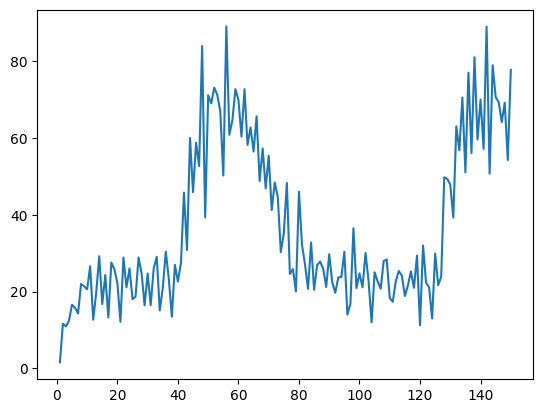

86.00000000000001


In [196]:


sim_t = sim.trange()

plt.plot(sim_t*1000, sim.data[combine_probe], label="combine") # plot for the combine ensemble

plt.show()

listwtime = [] # list to store the time and the combine ensemble output
for i in range(0, len(sim.data[combine_probe])):
    if sim.data[combine_probe][i] > 0:
        listwtime.append([sim.data[combine_probe][i], sim_t[i]])
        
goodtime = [] # list to store the time of the first and last LED
for i in range(0, len(listwtime)):
    if sim.data[combine_probe][i] > 84:
        goodtime.append([listwtime[i][1]])
     
timedif = (float(goodtime[1][0]) - float(goodtime[0][0]))*1000 # time difference between the first and last LED in milliseconds

print(timedif)
# print(goodtime[1])
# print(listwtime)
# print(sim.data[combine_probe], sim_t)

plt.show()

In [197]:
# # algorithim to get the time of the first LED and Last LED without Nengo

# # initial variables and ists
# sim_t = sim.trange()
# timelist = []
# neuron_data_start = []
# neuron_data_end = []
# timelistend = []


# for n in range(
#     0, len(pixel_coordinates)
# ):  # loop to get the data for each neuron around the first and last LED, since both cover 10x10 area of neurons the lenght of either list can be used
#     start_spiking = False
#     end_spiking = False
#     for i in range(
#         0, len(sim_t)
#     ):  # loop to get the data for each time step, uses the length of the simulation time as each time step is 1ms
#         neuron_data_start.append(
#             sim.data[probestart[n]]
#         )  # list of the probed data for the neurons around the first LED
#         neuron_data_end.append(
#             sim.data[probeend[n]]
#         )  # list of the probed data for the neurons around the last LED
#         if (
#             start_spiking is False
#             and neuron_data_start[n][i] > 0
#             and neuron_data_start[n][i + 2] > 0
#         ):  # added i+2 to make sure the spike is not a fluke,two timsteps ahead becuase it takes one to go back down to 0 and then another to go back up to 1.
#             time = [n, i]  # list of the neuron index, and time of spike
#             timelist.append(
#                 time
#             )  # list of all the neurons that spiked around the first LED
#             start_spiking = True
#         if (
#             end_spiking is False
#             and neuron_data_end[n][i] > 0
#             and neuron_data_end[n][i + 2] > 0
#         ):  # added i+2 to make sure the spike is not a fluke
#             timeend = [n, i]  # list of the neuron index, and time of spike
#             timelistend.append(
#                 timeend
#             )  # list of all the neurons that spiked around the last LED
#             end_spiking = True

# # #computing avg start time
# # model2 = nengo.Network(label="computeavg")
# # with model2:
# #     A = []
# #     timeensemble = []
# #     for i in range(0, len(timelist)):
# #         A.append(nengo.Node(timelist[i][1]/len(timelist)))
# #         timeensemble.append(nengo.Ensemble(n_neurons=1000, dimensions=1, radius=1))
# #         nengo.Connection(A[i], timeensemble[i])
# #     sum = nengo.Ensemble(n_neurons=1000, dimensions=1, radius=1)
# #     for i in range(0, len(timelist)):
# #         nengo.Connection(timeensemble[i], sum)

# #     probe = nengo.Probe(sum)
    

# # with nengo.Simulator(model2) as sim2:
# #         sim2.run(1)

# #plt.plot(sim_t, sim2.data[sum], label="time")

# # timesumstart = 0
# # for i in range(0, len(timelist)):
# #     timesumstart += timelist[i][1]
# # avg = timesumstart / len(timelist)

# # # computing avg end time
# # timesumend = 0
# # for i in range(0, len(timelistend)):
# #     timesumend += timelistend[i][1]
# # avgend = timesumend / len(timelistend)

# # print("Average start time")
# # print(avg)
# # print("Average end time")
# # print(avgend)

# # print("travel time")
# # print(avgend - avg)

# # from random import randrange

# # start = randrange(100)
# # end = randrange(100)

# # plt.plot(
# #     sim_t, neuron_data_start[start], label="Positive Spikes"
# # )  # shows an example graph of the data for a random neuron around the first LED
# # plt.plot(
# #     sim_t, neuron_data_end[end], label="Negative Spikes"
# # )  # shows an example graph of the data for a random neuron around the last LED
# # print("Random neuron around the first LED")
# # print(start)
# # print("Random neuron around the last LED")
# # print(end)


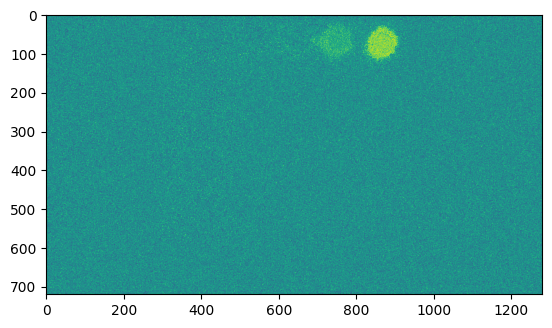

In [198]:
#display the neuron processed video
sim_t = sim.trange()
shape = (len(sim_t), img_height, img_width)

output_spikes_pos = (
    sim.data[probes][:, 0 : img_height * img_width].reshape(shape) * sim.dt
)
output_spikes_neg = (
    sim.data[probes][:, img_height * img_width : img_height * img_width * 2].reshape(
        shape
    )
    * sim.dt
)

dt_frame = 0.01  # this is in seconds
t_frames = dt_frame * np.arange(int(round(t_length_s / dt_frame)))

fig = plt.figure()

imgs = []
for t_frame in t_frames:
    t0 = t_frame
    t1 = t_frame + dt_frame
    m = (sim_t >= t0) & (sim_t < t1)

    frame_img = np.zeros((img_height, img_width))
    frame_img -= output_spikes_neg[m].sum(axis=0)
    frame_img += output_spikes_pos[m].sum(axis=0)
    frame_img = frame_img / np.abs(frame_img).max()

    img = plt.imshow(frame_img[:, ::1], vmin=-1, vmax=1, animated=True)
    imgs.append([img])

ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_jshtml())